In [1]:
import xarray as xr
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from time import time
import scipy 

era5_variables_dict = {
    '10m_u_component_of_wind': {
        'plevel': None,
        'short_name': 'u10'
    }, 
    '10m_v_component_of_wind': {
        'plevel': None,
        'short_name': 'v10'
    }, 
    '2m_temperature': {
        'plevel': None,
        'short_name': 't2m'
    }, 
    'mean_sea_level_pressure': {
        'plevel': None,
        'short_name': 'msl'
    }, 
    'sea_surface_temperature': {
        'plevel': None,
        'short_name': 'sst'
    }, 
    'surface_net_solar_radiation': {
        'plevel': None,
        'short_name': 'ssr'
    }, 
    'surface_net_thermal_radiation': {
        'plevel': None,
        'short_name': 'str'
    }, 
    'sea_ice_cover': {
        'plevel': None
    }, 
    'land_sea_mask': {
        'plevel': None
    }, 
    'geopotential': {
        'plevel': '500',
        'short_name': 'z'
    }
}
DATA_DIRECTORY = '/oak/stanford/groups/earlew/yuchen'

### Inputs/outputs

In [48]:
nsidc_sic = xr.open_dataset(f'{DATA_DIRECTORY}/NSIDC/seaice_conc_monthly_all.nc')

# For some reason, there are two months containing missing data (all the sea ice extent is NaN)
# For now, just remove those times from consideration 
#sidc_sic = nsidc_sic.sel(time=nsidc_sic.time[np.isnan(nsidc_sic.siconc).sum(dim=('x', 'y')) == 0])

#land_mask = np.logical_or(nsidc_sic.siconc.isel(time=0) == 2.53, nsidc_sic.siconc.isel(time=0) == 2.54)
#all_zeros_mask = np.sum(nsidc_sic.siconc == 0, axis=0) == len(nsidc_sic.time)
#land_and_open_ocean_mask = ~np.logical_or(land_mask.values, all_zeros_mask.values)

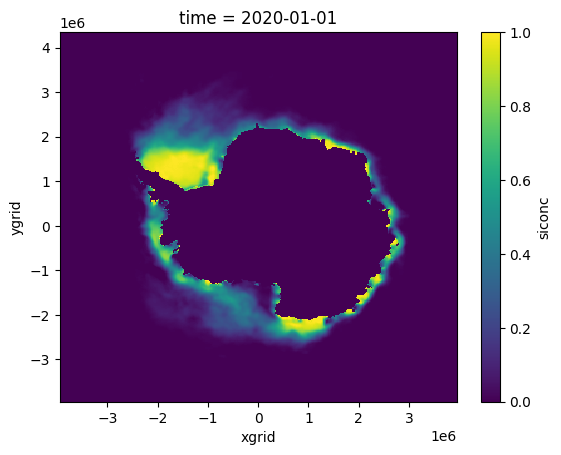

In [53]:
xr.open_dataset(f'{DATA_DIRECTORY}/sicpred/linear_forecasts/2020-01_all_years_linear_forecast.nc').siconc.plot()

In [43]:
TRAIN_MONTHS = pd.date_range(start='1981-01-01', end='2014-12-01', freq='MS')

vars_to_normalize = ["10m_u_component_of_wind"]
save_dir = os.path.join(DATA_DIRECTORY, "sicpred/normalized_inputs")

for var_name in vars_to_normalize:
    if os.path.exists(os.path.join(save_dir, f"{var_name}_norm.nc")):
        print(f"Already found normalized file for {var_name}. Skipping...")
        continue

    print(f"Normalizing {var_name}...")
    if var_name == "siconc":
        ds = xr.open_dataset(f"{DATA_DIRECTORY}/NSIDC/seaice_conc_monthly_all.nc")
        da = ds[var_name].sel(time=TRAIN_MONTHS)

    elif var_name == "geopotential":
        ds = xr.open_dataset(f"{DATA_DIRECTORY}/ERA5/{var_name}_500hPa_SPS.nc")
        da = ds[era5_variables_dict[var_name]["short_name"]].sel(time=TRAIN_MONTHS)

    else:
        if not os.path.exists(f"{DATA_DIRECTORY}/ERA5/{var_name}_SPS.nc"):
            raise FileNotFoundError(f"{DATA_DIRECTORY}/ERA5/{var_name}_SPS.nc does not exist!")

        ds = xr.open_dataset(f"{DATA_DIRECTORY}/ERA5/{var_name}_SPS.nc")
        da = ds[era5_variables_dict[var_name]["short_name"]].sel(time=TRAIN_MONTHS)

    print("Calculating means and stdev...", end="")
    monthly_means = da.groupby("time.month").mean("time")
    monthly_stdevs = da.groupby("time.month").std("time")
    print("done!")
    
    months = da['time'].dt.month
    normalized_da = xr.apply_ufunc(
        lambda x, m, s: (x - m) / s,
        da,
        monthly_means.sel(month=months),
        monthly_stdevs.sel(month=months),
        output_dtypes=[da.dtype]
    )

    os.makedirs(save_dir, exist_ok=True)
    print("Saving...", end="")
    #normalized_da.to_netcdf(os.path.join(save_dir, f"{var_name}_norm.nc"))
    print("done!")

        

Normalizing 10m_u_component_of_wind...
Calculating means and stdev...

/home/users/yucli/miniconda3/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/users/yucli/miniconda3/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/users/yucli/miniconda3/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/users/yucli/miniconda3/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/users/yucli/miniconda3/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=o

done!
Saving...done!


7/17 SST below sea ice has very very small standard deviations ($\sigma \sim \mathcal{O}(0.0001)$) since it is in equilibrium with the sea ice. So $(x - \mu)/\sigma$ is a small number over a small number. Normalized values don't really make too much physical sense.

One option is to set a threshold minimum bound for $x - \mu$ for SST only, and set the normalized value to 0 (since we expect SST under sea ice to be $\approx T_f$)

Here is an example plotted below:

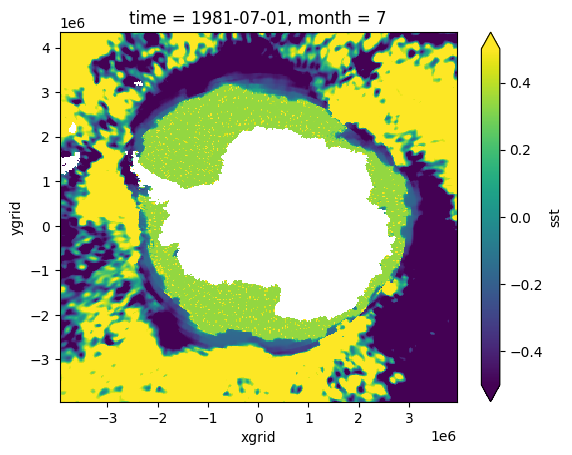

In [126]:
xr.open_dataset(f"{DATA_DIRECTORY}/sicpred/normalized_inputs/sea_surface_temperature_norm.nc").sst.isel(time=6).plot(cmap='viridis', vmin=-0.5, vmax=0.5)

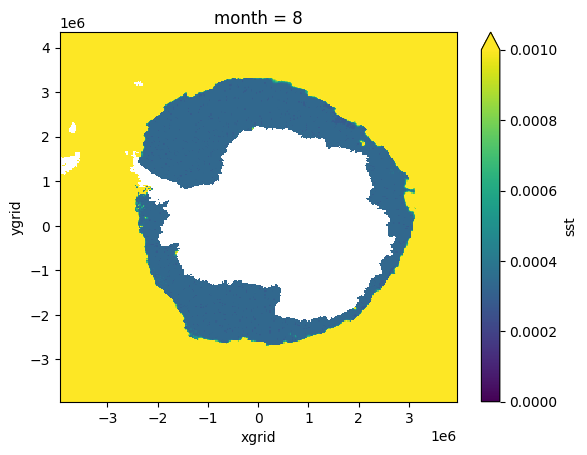

In [130]:
xr.open_dataset(f"{DATA_DIRECTORY}/sicpred/normalized_inputs/sea_surface_temperature_stdev.nc").sst.isel(month=7).plot(cmap='viridis', vmin=0, vmax=0.001)